# Imports

In [1]:
import numpy as np
import sklearn as sk
import scipy.io as scio
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import re

import skimage as skimg
from skimage.feature import hog

# Data Loading and Partitioning

In [2]:
def load_dataset(datasetname):
    location = 'hw01_data/'
    if datasetname == 'mnist':
        location = location + datasetname + '/'
        train_data = scio.loadmat(location + 'train.mat') #load .mat files in python
        test_data = scio.loadmat(location + 'test.mat')

        train_data = train_data['trainX']
        indices = np.random.permutation(len(train_data))

        validation_data = train_data[indices[:10000], :] #First 10000 indices + all columns reserved for validation set
        train_data = train_data[indices[10000:], :] #rest i.e (from 10000th row till end) is train set
        test_data = test_data['testX']



    elif datasetname == 'spam':
        location = location + datasetname + '/'
        spam_data = scio.loadmat(location + 'spam_data.mat')
        train_data = spam_data['training_data']
        test_data = spam_data['test_data']
        train_labels = spam_data['training_labels']

        indices = np.random.permutation(len(train_data))

        split_index = int(0.8 * (len(train_data)))

        validation_data = train_data[indices[split_index:], :]
        train_data = train_data[indices[:split_index], :]
        
        validation_labels = train_labels[0][indices[split_index:]]
        train_labels = train_labels[0][indices[:split_index]]
        
        ##Let's just compact train and validation to match with the return type
        train_data = (train_data,train_labels)
        validation_data = (validation_data,validation_labels)

    elif datasetname == 'cifar':
        location = location + datasetname + '/'
        train_data = scio.loadmat(location + 'train.mat')
        test_data = scio.loadmat(location + 'test.mat')

        train_data = train_data['trainX']
        indices = np.random.permutation(len(train_data))

        validation_data = train_data[indices[:5000], :]
        train_data = train_data[indices[5000:], :]
        test_data = test_data['testX']

    return train_data, validation_data, test_data

# Training a Classifier

In [3]:
#This function takes the training dataset and C as parameter and returns the trained classifier.

def classify_train(train_data,c=None):
    train_x = train_data[:,:-1]
    train_y = train_data[:,-1]
    if c is not None:
        clf = SVC(kernel='linear', C = c)
    else:
        clf = SVC(kernel="linear")
    clf.fit(train_x, train_y)
    return clf

## Prediction

In [4]:
#This function takes the dataset and the trained classifier to return the prediction obtained.

def predict(data,clf):

    data_x = data[:,:-1]
    data_y = data[:,-1]
    predicted_y = clf.predict(data_x)
    
    return predicted_y

# MNIST

In [5]:
mnist_train, mnist_val, mnist_test = load_dataset('mnist')
# print(mnist_test[0, :])

### Training on different number of examples

In [ ]:
iterations = [100,200,500,1000,2000,5000,10000]
val_error_rates = []
train_error_rates =[]
classifiers = []
train_y = mnist_train[:,-1]
val_y = mnist_val[:,-1]

for entry in iterations:
    clf = classify_train(mnist_train[:entry,:])

    #train accuracy
    train_predicted_label = predict(mnist_train, clf)
    train_accuracy =  len(list(filter(lambda y: y, train_y == train_predicted_label)))/float(len(train_y))
    train_error_rates.append(1-train_accuracy)
    

    #validation accuracy
    val_predicted_label = predict(mnist_val, clf)
    val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
    val_error_rates.append(1-val_accuracy)
    classifiers.append(clf)

### Error Plots

In [ ]:
MNIST_fig = plt.figure()
plt.plot(iterations, list(map(lambda x:x*100,train_error_rates)),'bo-')
plt.plot(iterations, list(map(lambda x:x*100,val_error_rates)),'ro-')
plt.legend(["Training Error","Validation Error"], loc='upper right')
plt.xlabel("No. of Training Examples")
plt.ylabel("Error Rate (in %)")
plt.title("MNIST No. of Training Examples Vs Error Rates")
plt.axis([0, 10500,0,100])
plt.show()
MNIST_fig.savefig("MNIST_Training_Examples.png")

### Finding the best C

In [ ]:
error_rates = []
classifiers = []
accuracies = []
# c_values = [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1] #best for 1e-6
#Accuracies : [0.6626, 0.8849, 0.9155, 0.9234, 0.9115, 0.904, 0.904, 0.904, 0.904]

# c_values = [2e-7,4e-7,6e-7,8e-6,2e-6,4e-6,6e-6,8e-6] #best for 6e-7
#accuracies = [0.9193, 0.9208, 0.9222, 0.9122, 0.9193, 0.9142, 0.9133, 0.9122] 


for c in c_values:
    clf = classify_train(mnist_train[:10000,:],c)

    #validation accuracy
    
    val_predicted_label = predict(mnist_val, clf)
    val_y = mnist_val[:,-1]
    val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
    error_rates.append(1-val_accuracy)
    accuracies.append(val_accuracy)
    classifiers.append(clf)
print(accuracies)
    

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from time import time

# # Utility function to report best scores
# def report(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")
            
# train_x = mnist_train[:2000,:-1]
# train_y = mnist_train[:2000,-1]
# param_grid = [
#   {'C': [1e-1, 1e-2, 1e-3, 1e0], 'kernel': ['linear']},
#   {'C': [1e-1, 1e-2, 1e-3, 1e0], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# clf = SVC()
# grid_search = GridSearchCV(clf, param_grid=param_grid)
# start = time()
# grid_search.fit(train_x, train_y)

# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid_search.cv_results_['params'])))
# report(grid_search.cv_results_)

In [6]:
train_x = mnist_train[:,:-1]
train_y = mnist_train[:,-1]
clf = SVC(C=6e-7, kernel='linear', verbose=True)
clf.fit(train_x,train_y)
val_x = mnist_val[:,:-1]
val_y = mnist_val[:,-1]
val_predicted_label = clf.predict(val_x)
val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
print(val_accuracy)

[LibSVM]0.9461


### For the final run let's combine train and validation and train the classifier on the whole data

In [6]:
train_x = np.vstack([mnist_train[:,:-1],mnist_val[:,:-1]])
train_y = np.concatenate([mnist_train[:,-1],mnist_val[:,-1]])

In [8]:
#Using the parameters that we found to be the best
clf = SVC(C=6e-7, kernel='linear', verbose=True)
clf.fit(train_x,train_y)

[LibSVM]

SVC(C=6e-07, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [9]:
# selected_clf = classifiers[np.argmin(error_rates)]

predicted_label = clf.predict(mnist_test)


In [10]:
output = pd.DataFrame(predicted_label)
output.columns = ["Category"]
output.index.names = ["Id"]
output.to_csv(path_or_buf="submission_mnist.csv", sep=",")

## Experiments with HOG and SIFT to improve kaggle score

In [21]:
train_ims = np.reshape(train_x,[60000,28,28])
test_ims = np.reshape(mnist_test,[10000,28,28])

In [31]:
train_features=hog(train_ims[0,:,:], orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1))
for i in range(1,60000):
    train_features = np.vstack([train_features,hog(train_ims[i,:,:], orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1))])
    if i%5000==0:
        print(i,end=": ")
        print(train_features.shape)
train_features.shape


5000: (5001, 392)
10000: (10001, 392)
15000: (15001, 392)
20000: (20001, 392)
25000: (25001, 392)
30000: (30001, 392)
35000: (35001, 392)
40000: (40001, 392)
45000: (45001, 392)
50000: (50001, 392)
55000: (55001, 392)


(60000, 392)

In [ ]:
test_features=hog(test_ims[0,:,:], orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1))
for i in range(1,10000):
    test_features = np.vstack([test_features,hog(test_ims[i,:,:],orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1))])
test_features.shape

(10000, 392)

In [ ]:
clf = SVC(kernel='linear')
scores = cross_val_score(clf, train_features, train_y, cv=5)
print(scores)

In [ ]:
clf.fit(train_features, train_y)

In [ ]:
predicted_label = clf.predict(test_features)
output = pd.DataFrame(predicted_label)
output.columns = ["Category"]
output.index.names = ["Id"]
output.to_csv(path_or_buf="submission_mnist.csv", sep=",")

# CIFAR

In [6]:
cifar_train, cifar_val, cifar_test = load_dataset('cifar')

### Training on different number of examples

In [7]:
iterations = [100,200,500,1000,2000,5000]
train_error_rates = []
val_error_rates = []
classifiers = []
train_y = cifar_train[:,-1]
val_y = cifar_val[:,-1]
for entry in iterations:
    clf = classify_train(cifar_train[:entry,:])

    #train accuracy
    train_predicted_label = predict(cifar_train, clf)
    train_accuracy = len(list(filter(lambda y: y, train_y == train_predicted_label)))/float(len(train_y))
    train_error_rates.append(1-train_accuracy)

    #validation accuracy
    val_predicted_label = predict(cifar_val, clf)
    val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
    val_error_rates.append(1-val_accuracy)
    print("done : "+ str(entry))
    classifiers.append(clf)

done : 100
done : 200
done : 500
done : 1000
done : 2000
done : 5000


### Error plots

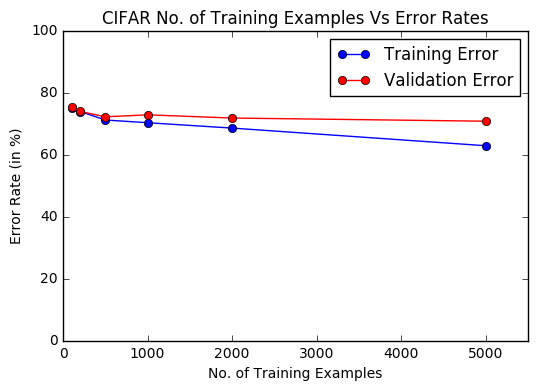

In [8]:
CIFAR_fig = plt.figure()
plt.plot(iterations, list(map(lambda x:x*100,train_error_rates)),'bo-')
plt.plot(iterations, list(map(lambda x:x*100,val_error_rates)),'ro-')
plt.legend(["Training Error","Validation Error"], loc='upper right')
plt.xlabel("No. of Training Examples")
plt.ylabel("Error Rate (in %)")
plt.title("CIFAR No. of Training Examples Vs Error Rates")
plt.axis([0, 5500,0,100])
plt.show()
CIFAR_fig.savefig("CIFAR_Training_Examples.png")

### Finding the best C

In [ ]:
error_rates = []
classifiers = []
c_values = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
for c in c_values:
    clf = classify_train(cifar_train[:1000,:],c)

    #validation accuracy
    val_predicted_label = predict(cifar_val, clf)
    val_y = cifar_val[:,-1]
    val_accuracy = len(list(filter(lambda y: y, val_y != val_predicted_label)))/float(len(val_y))
    error_rates.append(1-val_accuracy)
    classifiers.append(clf)
print(error_rates)

In [ ]:
train_x = cifar_train[:,:-1]
train_y = cifar_train[:,-1]
clf = SVC(kernel='poly', C =1e-3, degree=2)
clf.fit(train_x,train_y)
val_x = cifar_val[:,:-1]
val_y = cifar_val[:,-1]
val_predicted_label = clf.predict(val_x)
val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
print(val_accuracy)

In [ ]:
train_x = cifar_train[:,:-1]
train_y = cifar_train[:,-1]
print(train_y.shape)

In [ ]:
# selected_clf = classifiers[np.argmin(error_rates)]
predicted_label = clf.predict(cifar_test)
predicted_label

# Spam - Ham

In [11]:
spam_train, spam_val, spam_test = load_dataset('spam')

In [12]:
train_x,train_y = spam_train
val_x,val_y= spam_val
len(train_x)

4137

### Training on different number of examples

In [ ]:
iterations = [100,200,500,1000,2000]

val_error_rates = []
train_error_rates =[]

classifiers = []

for entry in iterations:
    clf = SVC(kernel="linear")
    clf.fit(train_x[:entry,:],train_y[:entry])
    #train accuracy
    train_predicted_label = clf.predict(train_x)
    train_accuracy =  len(list(filter(lambda y: y, train_y == train_predicted_label)))/float(len(train_y))
    train_error_rates.append(1-train_accuracy)
    

    #validation accuracy
    val_predicted_label = clf.predict(val_x)
    val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
    val_error_rates.append(1-val_accuracy)
    classifiers.append(clf)

### Error plot

In [ ]:
Spam_fig = plt.figure()
plt.plot(iterations, list(map(lambda x:x*100,train_error_rates)),'bo-')
plt.plot(iterations, list(map(lambda x:x*100,val_error_rates)),'ro-')
plt.legend(["Training Error","Validation Error"], loc='upper right')
plt.xlabel("No. of Training Examples")
plt.ylabel("Error Rate (in %)")
plt.title("SPAM-HAM No. of Training Examples Vs Error Rates")
plt.axis([0, 2500,0,100])
plt.show()
Spam_fig.savefig("SPAM_Training_Examples.png")

In [ ]:
# clf = SVC(kernel='rbf',gamma=0.8e-2,C=55)
# clf.fit(train_x,train_y)
# val_predicted_label = clf.predict(val_x)
# val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
# print(val_accuracy)

In [ ]:
clf = SVC(kernel='linear',C=55)
clf.fit(train_x,train_y)
val_predicted_label = clf.predict(val_x)
val_accuracy = len(list(filter(lambda y: y, val_y == val_predicted_label)))/float(len(val_y))
print(val_accuracy)

### K fold Cross Validation

In [ ]:
train_x = np.vstack([train_x,val_x])
train_y = np.concatenate([train_y,val_y])
C_values = list(range(10,200,10))
scores = []
for c in C_values: 
    clf = SVC(kernel='linear',C=c)
    score = cross_val_score(clf, train_x, train_y, cv=5)
    avg_score = np.mean(score)
    scores.append(avg_score)
    print(c,end=": ")
    print(avg_score)
    
    

### Trying TfIdf for better score

In [13]:
spam_dir = "hw01_data/spam/spam/"
ham_dir ="hw01_data/spam/ham/"
test_dir = "hw01_data/spam/test/"
spam_files = filter(lambda x:x.endswith('.txt') ,os.listdir(spam_dir))
ham_files = filter(lambda x:x.endswith('.txt') ,os.listdir(ham_dir))
test_files_len = len(list(filter(lambda x:x.endswith('.txt'),os.listdir(test_dir))))

In [14]:
df = pd.DataFrame(columns=("text","label")) # create an empty dataframe
count=0
for fn in spam_files:
    fn=spam_dir+fn
    with open(fn,"r",encoding='utf-8', errors='ignore') as spam:
        df.loc[count] = [spam.read(),1]
        count+=1
        
for fn in ham_files:
    fn=ham_dir+fn
    with open(fn,"r",encoding='utf-8', errors='ignore') as ham:
        df.loc[count] = [ham.read(),0]
        count+=1
df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe

In [15]:
# df_val = df.ix[:1000]
# df_train = df.ix[1001:]

In [16]:
#do the same thing for test dataset
df_test = pd.DataFrame(columns=("text","label"))
count=0
for fn in range(test_files_len):
    fn=test_dir+str(fn)+'.txt'
    with open(fn,"r",encoding='utf-8', errors='ignore') as test:
        df_test.loc[count] = [test.read(),"UNK"]
        count+=1

In [17]:
#Tfidf
df_train =df
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
X_train = vectorizer.fit_transform(df_train.text)
# X_val = vectorizer.transform(df_val.text)
X_test = vectorizer.transform(df_test.text)


In [18]:
#classifier

# clf = SVC(kernel='linear')
clf = SVC(kernel='rbf',gamma=0.002,C=300)
scores = cross_val_score(clf, X_train, df_train.label, cv=5)
print(scores)
clf.fit(X_train,df_train.label)
# val_predicted_label = clf.predict(X_val)
# val_accuracy = len(list(filter(lambda y: y, df_val.label == val_predicted_label)))/float(len(df_val))
# print(val_accuracy)

[ 0.99130435  0.99130435  0.98839458  0.98839458  0.98646035]


SVC(C=300, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.002, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
predicted_label = clf.predict(X_test)
output = pd.DataFrame(predicted_label)
output.columns = ["Category"]
output.index.names = ["Id"]
output.to_csv(path_or_buf="submission_spam.csv", sep=",")

### Checking the frequency of words to decide optimum features to be used in featurizer.py

In [ ]:
# def tokenizer(text):
#     return re.split(" |\n",text)
# df_spam = df_train[df_train.label==0]

In [ ]:
# df_spam=df_spam.reset_index()

In [ ]:
# corpus ={}
# for i in range(len(df_spam)):
#     for token in tokenizer(df_spam.text[i]):
#         corpus[token] = corpus.get(token,0)+1

In [ ]:
# import operator
# sorted(corpus.items(), key=operator.itemgetter(1),reverse=True)